In [40]:
import sys
import os
import pathlib
import json
import pyvista as pv
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


working_dir = pathlib.Path(os.path.abspath(""))
sys.path.append(str(working_dir.parent))
from util import find_runs  # noqa: E402

### Load data and calculate error

In [41]:
def load_data(runs_dir: pathlib.Path, timestep: int) -> pd.DataFrame:
    """Load the data from the runs in the given directory. Only load the given timestep.

    Args:
        runs_dir: The directory containing the runs.
        timestep: The timestep to load.

    Return:
        A pandas DataFrame containing the data. The index is the grid spacing and
        the columns are the different mappings.
    """

    # Find the runs, we are interested in
    runs = find_runs(runs_dir)
    runs = sorted(runs)

    # Load the data
    data = {} # Raw data: {column: {grid_spacing: error_value}}

    for run_path in runs:

        # Read parameters of the run
        with open(run_path / "parameters.json") as file:
            parameters = json.load(file) 

        # Generate descriptive column name
        column_name = {
            "nearest-neighbor": "NN",
            "rbf-pum-direct": "RBF",
        }[parameters["mapping"]]

        if parameters["mapping"] == "rbf-pum-direct":
            column_name += (
                "_"
                + {
                    "compact-polynomial-c0": "CP0",
                    "compact-polynomial-c2": "CP2",
                    "compact-polynomial-c4": "CP4",
                    "compact-polynomial-c6": "CP6",
                    "compact-polynomial-c8": "CP8",
                }[parameters["basis_function"]]
            )
            column_name += f"_{parameters['support_radius']}"

        # Calculate grid spacing from refinement level
        grid_spacing = 1 / 2 ** parameters["refinement"]

        # Calculate velocity error
        try:
            file_name = f"refinement-{parameters["refinement"]}_particles_{timestep:06}.pvtu"
            mesh = pv.read(run_path / "solution" / file_name)

            mesh["error"] = np.linalg.norm(mesh["velocity"] - mesh["analytical_velocity"], axis=1)

            mean_error = mesh["error"].mean()
        
        except FileNotFoundError:
            mean_error = np.nan

        # Insert error into data dict
        if column_name not in data:
            data[column_name] = {}
        data[column_name][grid_spacing] = mean_error

    # Convert data dict to pandas DataFrame
    return pd.DataFrame(data).sort_index(axis=0, ascending=False).sort_index(axis=1)

df = load_data(working_dir, 2400)
df

,NN,RBF_CP0_0.5,RBF_CP6_0.5
0.125000,0.110019,0.018518,9.952380e-03
0.062500,0.056519,0.003490,4.824453e-04
0.031250,0.028887,0.001041,3.554930e-05
0.015625,0.013295,0.000274,2.382008e-06
0.007812,0.006924,0.000072,1.193463e-07


### Plot the error

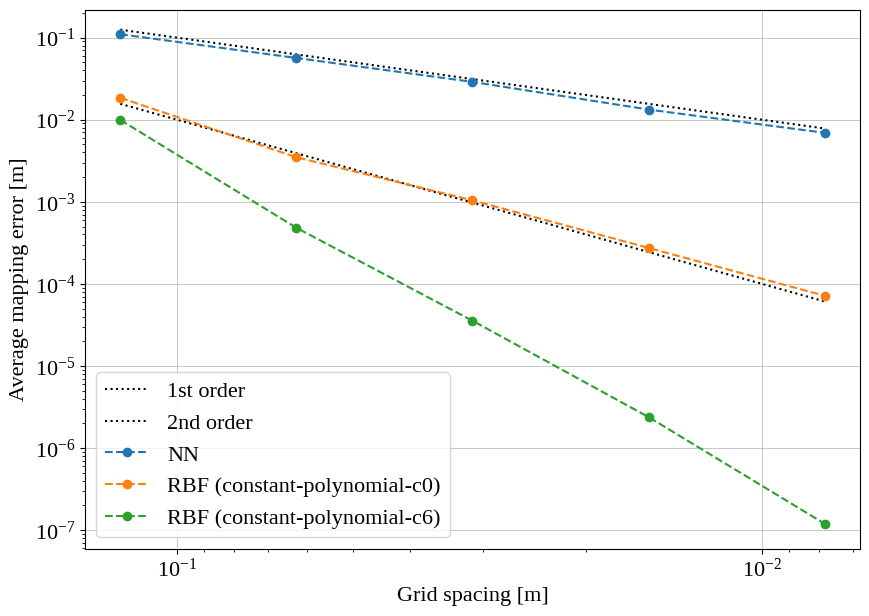

In [42]:
from matplotlib.axes import Axes


def plot_error_convergence(data: pd.DataFrame, title: str, reference_lines = True, ax: Axes = None):
    """Plot the velocity error at a given timestep over different grid resolutions.
    
    Args:
        fig
        data: A DataFrame containing the error data. The index should be the grid
            resolution. Each column will be plotted as a separate line. 
        title: Title of the plot.
        reference_lines: If True, plot reference lines for first and second order
            convergence.
        ax: The axes to plot on. If None, create a new figure and axes.
    """

    # Create figure and axes if not provided
    if ax is None:
        fig, ax = plt.subplots(figsize=(10, 7))
        plt.rcParams.update({
            "font.family": "serif",
            "font.serif": ["Liberation Serif"],
            "mathtext.fontset": "stix",
            "font.size": 16,
            "axes.labelsize": 16,
            "axes.titlesize": 16,
            "xtick.labelsize": 16,
            "ytick.labelsize": 16,
            "legend.fontsize": 16,
            "xtick.color": "black",
            "ytick.color": "black",
            "axes.labelcolor": "black",            
        })

    # Plot reference lines
    if reference_lines:
        # First order convergence
        ax.plot(data.index, data.index, linestyle="dotted", color="black", label="1st order")
        # Second order convergence
        ax.plot(data.index, data.index ** 2, linestyle="dotted", color="black", label="2nd order")

    # Plot the data
    # for column in data.columns:
    #     ax.plot(data.index, data[column], label=column)
    ax.plot(data.index, data["NN"], label="NN", marker="o", linestyle="--")
    ax.plot(data.index, data["RBF_CP0_0.5"], label="RBF (constant-polynomial-c0)", marker="o", linestyle="--")
    ax.plot(data.index, data["RBF_CP6_0.5"], label="RBF (constant-polynomial-c6)", marker="o", linestyle="--")


    # Add labels and legend
    # ax.set_title(title)
    ax.legend()
    ax.grid(linewidth=0.5)

    # Configure axes
    ax.set_xlabel("Grid spacing [m]")
    ax.set_xscale("log")
    ax.invert_xaxis()

    # ax.set_xlim(2**-3, 2**-7)
    
    ax.set_ylabel("Average mapping error [m]")
    ax.set_yscale("log")
    ax.set_ylim(data.min().min() / 2, data.max().max() * 2)
    fig.savefig(working_dir / "vortex_tracing_mapping_error_vs_grid_spacing.pdf", bbox_inches="tight")

plot_error_convergence(df, "")
